In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr
import cartopy.crs as ccrs 
from cartopy.util import add_cyclic

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5 = ERA5.sel(valid_time="2024-04-02T12:00:00", pressure_level=500, latitude=slice(89.9,-89.9))

# Data manipulation to calculate the quanties
a = 6370000
ERA5_wrapped = (ERA5.pad(longitude=1, mode="wrap").pad(latitude=1, mode="edge")
                ).assign_coords(longitude=ERA5.longitude.pad(longitude=1, mode="reflect", reflect_type="odd"),
                                latitude=ERA5.latitude.pad(latitude=1, mode="reflect", reflect_type="odd"))

ERA5_dUdTheta = (ERA5_wrapped["u"]* np.cos(np.deg2rad(ERA5_wrapped["latitude"]))).differentiate("latitude")
ERA5_dVdPhi = ERA5_wrapped["v"].differentiate("longitude")
ERA5_VOR = (a*np.cos(np.deg2rad(ERA5_wrapped["latitude"])))**(-1) * (ERA5_dVdPhi - ERA5_dUdTheta)
ERA5_VOR = ERA5_VOR.sel(longitude=slice(0,359.9), latitude=slice(89.9,-89.9))

In [4]:
# Prepare data for plotting
Lon, Lat = np.meshgrid(ERA5_VOR["longitude"], ERA5_VOR["latitude"])
Data = ERA5_VOR.data
Data_p, Lon_p, Lat_p = add_cyclic(Data, x=Lon, y=Lat, precision=0.00001)

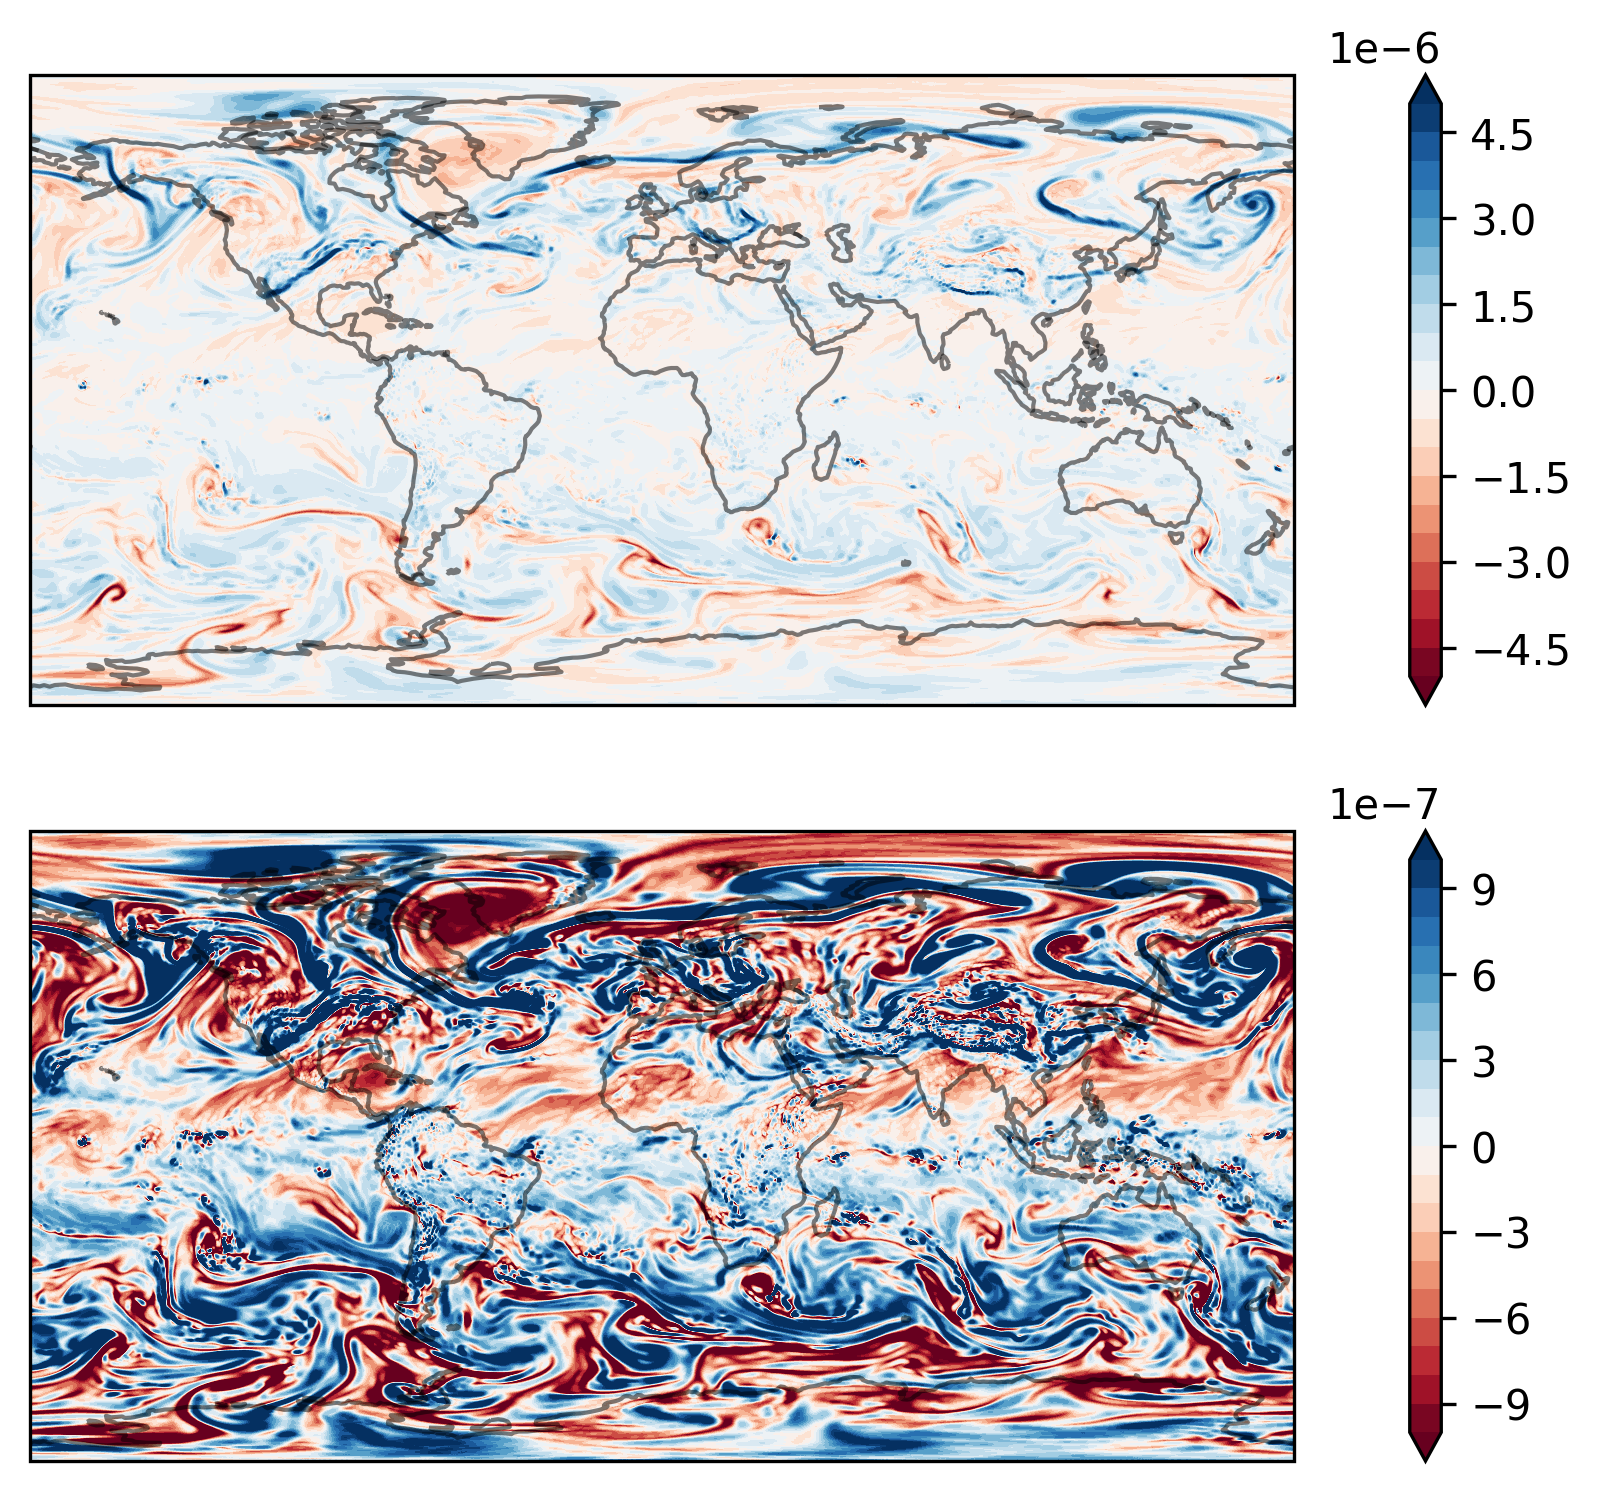

In [5]:
# Plotting 
fig = plt.figure(figsize=(10, 6), dpi=300)
ax1 = fig.add_subplot(2, 1, 1, projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection = ccrs.PlateCarree())

im1 = ax1.contourf(Lon_p, Lat_p, Data_p, transform = ccrs.PlateCarree(),
                   cmap= "RdBu",
                   extend="both", 
                   levels = np.arange(-5.0, 5.01, 0.5)*1E-6
                   )

cb1 = plt.colorbar(im1, ax=ax1)
ax1.coastlines(alpha=0.5)

im2 = ax2.contourf(Lon_p, Lat_p, Data_p, transform = ccrs.PlateCarree(), 
                   cmap= "RdBu",
                   extend="both", 
                   levels = np.arange(-1.0, 1.01, 0.1)*1E-6
                   )

cb2 = plt.colorbar(im2, ax=ax2)
ax2.coastlines(alpha=0.5)

plt.show()